## Introduction
This dataset contains traffic data that detects four types of vehicles: cars, buses, bikes, and trucks. The dataset includes the following columns:
* Time: Time record in HH:MM:SS format.
* Date: Day of the month.
* Day of the week: Name of the day.
* CarCount, BikeCount, BusCount, TruckCount: Counts of respective vehicles.
* Total: Total vehicle count.
* Traffic situation: Categorized into four classes (1-Heavy, 2-High, 3-Normal, 4-Low).

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import QuantileTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [21]:
# Load datasets
traffic_df = pd.read_csv('/kaggle/input/traffic-prediction-dataset/Traffic.csv')
traffic_two_month_df = pd.read_csv('/kaggle/input/traffic-prediction-dataset/TrafficTwoMonth.csv')

In [22]:
traffic_df['Traffic Situation'].value_counts()

Traffic Situation
normal    1669
heavy      682
high       321
low        304
Name: count, dtype: int64

In [23]:
# Combine datasets
traffic_df['Source'] = 'OneMonth'
traffic_two_month_df['Source'] = 'TwoMonth'
combined_df = pd.concat([traffic_df, traffic_two_month_df], ignore_index=True)

In [24]:
has_missing = combined_df.isnull().values.any()
print(f"Dataset has missing values: {has_missing}")

Dataset has missing values: False


## Exploratory Data Analysis (EDA)

In [25]:
# Distribution of vehicle counts

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("Car Counts", "Bike Counts", "Bus Counts", "Truck Counts"))

fig.add_trace(go.Histogram(x=combined_df['CarCount'], name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Histogram(x=combined_df['BikeCount'], name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Histogram(x=combined_df['BusCount'], name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Histogram(x=combined_df['TruckCount'], name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Distribution of Vehicle Counts', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Count")
fig.update_yaxes(title_text="Frequency")
fig.show()

In [26]:
# Distribution of the traffic situation

fig = px.pie(combined_df, names='Traffic Situation', title='Traffic Situation Distribution')
fig.update_layout(title_text='Traffic Situation Distribution', title_x=0.5, template='plotly_white')
fig.show()

In [27]:
# Distribution of vehicle counts

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("Car Counts by Day", "Bike Counts by Day", 
                                    "Bus Counts by Day", "Truck Counts by Day"))

fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['CarCount'],
                           name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['BikeCount'],
                           name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['BusCount'],
                           name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Box(x=combined_df['Day of the week'], y=combined_df['TruckCount'],
                           name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Vehicle Counts by Day', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Day of the Week")
fig.update_yaxes(title_text="Frequency")
fig.show()

In [28]:
# Distribution of traffic situations

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("Car Counts by Traffic Situation", "Bike Counts by Traffic Situation", 
                                    "Bus Counts by Traffic Situation", "Truck Counts by Traffic Situation"))

fig.add_trace(go.Box(x=combined_df['Traffic Situation'], y=combined_df['CarCount'],
                           name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Box(x=combined_df['Traffic Situation'], y=combined_df['BikeCount'],
                           name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Box(x=combined_df['Traffic Situation'], y=combined_df['BusCount'],
                           name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Box(x=combined_df['Traffic Situation'], y=combined_df['TruckCount'],
                           name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Vehicle Counts by Traffic Situation', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Traffic Situation")
fig.update_yaxes(title_text="Frequency")
fig.show()

In [29]:
# Total vehicle count by traffic situation

fig = px.box(combined_df, x='Traffic Situation', y='Total', title='Total Vehicle Count by Traffic Situation',
            color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [30]:
# Vehicle count by source

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("Car Counts by Source", "Bike Counts by Source", 
                                    "Bus Counts by Source", "Truck Counts by Source"))

fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['CarCount'],
                           name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['BikeCount'],
                           name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['BusCount'],
                           name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Box(x=combined_df['Source'], y=combined_df['TruckCount'],
                           name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Vehicle Counts by Source', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Source")
fig.update_yaxes(title_text="Frequency")
fig.show()

In [31]:
# Busiest hours of the day for the traffic

combined_df['Hour'] = pd.to_datetime(combined_df['Time'], format='%I:%M:%S %p').dt.hour

fig = px.box(combined_df, x='Hour', y='Total', title='Total Vehicle Count by Hour', color_discrete_sequence=['#9467bd'])
fig.update_layout(title_text='Total Vehicle Count by Hour', title_x=0.5, xaxis_title='Hour', yaxis_title='Total Count', template='plotly_white')
fig.show()

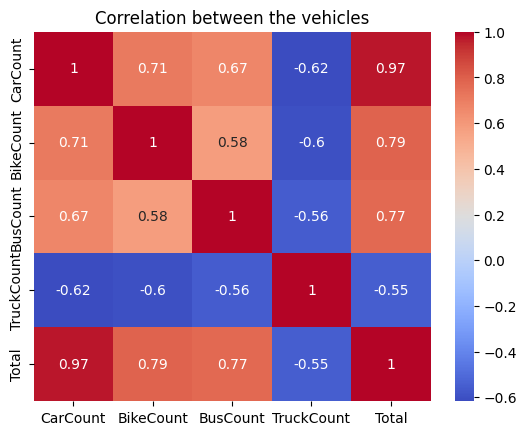

In [32]:
# Correlations between the vehicles

corr_matrix = combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation between the vehicles")
plt.show()

In [33]:
# distribution of vehicle counts on the weekend

combined_df['Weekend'] = combined_df['Day of the week'].isin(['Saturday', 'Sunday'])
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("Car Counts by Weekend", "Bike Counts by Weekend", 
                                    "Bus Counts by Weekend", "Truck Counts by Weekend"))

fig.add_trace(go.Box(x=combined_df['Weekend'], y=combined_df['CarCount'],
                           name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Box(x=combined_df['Weekend'], y=combined_df['BikeCount'],
                           name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Box(x=combined_df['Weekend'], y=combined_df['BusCount'],
                           name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Box(x=combined_df['Weekend'], y=combined_df['TruckCount'],
                           name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Vehicle Counts on Weekend', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Weekend")
fig.update_yaxes(title_text="Frequency")
fig.show()

## Data Preprocessing
* check missing values and duplicates
* scale the data

In [34]:
# Check for missing values and duplicates
print("Missing values in each column:")
print(combined_df.isnull().sum())

print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")

Missing values in each column:
Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
Source               0
Hour                 0
Weekend              0
dtype: int64
Number of duplicate rows: 0


In [35]:
# Normalize data using QuantileTransformer
scaler = QuantileTransformer(output_distribution='normal')
combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']] = scaler.fit_transform(combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']])

## Training Model

In [36]:
X = combined_df.drop(columns=["Traffic Situation"])
y = combined_df['Traffic Situation']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Preprocessing pipeline for numeric and categorical features
numeric_features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Hour']
categorical_features = ['Time', 'Date', 'Day of the week', 'Source', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [39]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CarCount', 'BikeCount',
                                                   'BusCount', 'TruckCount',
                                                   'Total', 'Hour']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Time', 'Date',
                                                   'Day of the week', 'Source',
                                                   'Weekend'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

## Evaluation

In [40]:
y_pred = model.predict(X_test)

In [41]:
# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9921612541993281
Classification Report:
              precision    recall  f1-score   support

       heavy       0.99      1.00      0.99       352
        high       1.00      0.97      0.99       148
         low       1.00      0.98      0.99       223
      normal       0.99      0.99      0.99      1063

    accuracy                           0.99      1786
   macro avg       0.99      0.99      0.99      1786
weighted avg       0.99      0.99      0.99      1786



In [42]:
# Inverse transform the normalized values to their original scale
inverse_transformed_data = scaler.inverse_transform(combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']])
combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount']] = inverse_transformed_data

In [43]:
# Check some predictions with the inverse-transformed data
input_features = X_test.iloc[0].to_dict()
input_features_df = pd.DataFrame([input_features])

predicted_output = model.predict(input_features_df)
print(f"Input features: {input_features}")
print(f"Predicted output for input features: {predicted_output}")

Input features: {'Time': '7:30:00 AM', 'Date': 12, 'Day of the week': 'Thursday', 'CarCount': 0.8957798188835897, 'BikeCount': 0.6674190444558499, 'BusCount': 1.8114574488804083, 'TruckCount': -1.7502216171233853, 'Total': 178, 'Source': 'OneMonth', 'Hour': 7, 'Weekend': False}
Predicted output for input features: ['heavy']
